##**Movie Recommendation System**

Hi everyone!
Let's first import all the necessary libraries

In [ ]:
!pip install fuzzywuzzy

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fuzzywuzzy import process
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Read movie and rating data from CSV files into pandas DataFrames

In [ ]:
movies_df = pd.read_csv('movies.csv', usecols=['movieId', 'title'],
                        dtype={'movieId': 'int32', 'title': 'str'})
rating_df = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating'],
                         dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

Display the first few rows of the movies and ratings DataFrames

In [ ]:
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
rating_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Merge movies and ratings DataFrames on the 'movieId' column

In [ ]:
df = pd.merge(rating_df, movies_df, on='movieId')
df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


  Drop rows with missing values in the 'title' column

In [ ]:
combine_movie_rating = df.dropna(axis=0, subset=['title'])

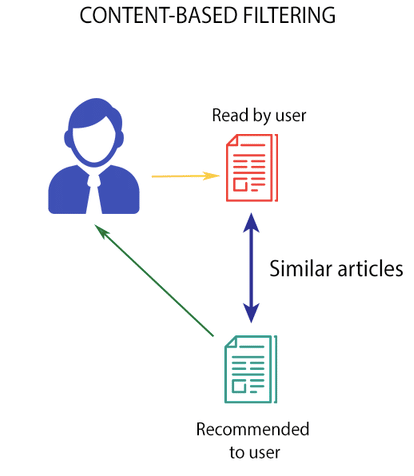

Count the total number of ratings for each movie and create a new DataFrame

In [ ]:
movie_ratingCount = (combine_movie_rating.groupby(by=['title'])['rating'].count().reset_index().rename(columns={'rating': 'totalRatingCount'})[['title', 'totalRatingCount']])
movie_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


Merge the combined movie and rating DataFrame with the movie rating count DataFrame

In [ ]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount, left_on='title', right_on='title',
                                                          how='left')
rating_with_totalRatingCount.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215


Set a popularity threshold (minimum number of ratings for a movie to be considered popular)

In [ ]:
popularity_threshold = 50

Filter movies that meet the popularity threshold

In [ ]:
rating_popular_movie = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_movie.shape

(41362, 5)

In [ ]:
rating_popular_movie.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215


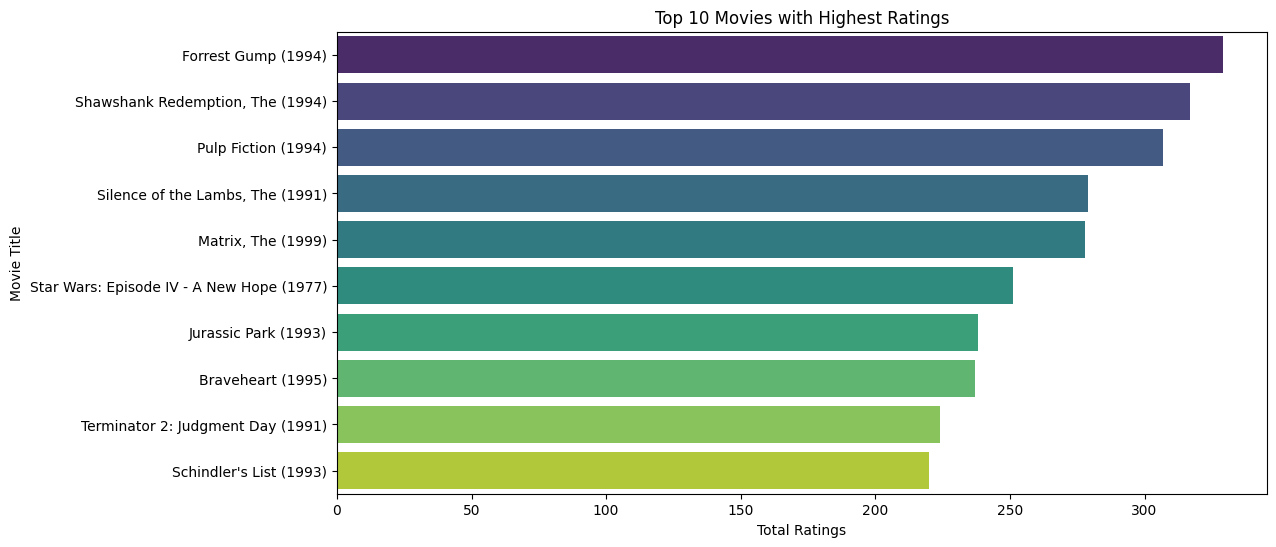

In [ ]:
top_movies = movie_ratingCount.sort_values(by='totalRatingCount', ascending=False).head(10)

# Plot the top 10 movies
plt.figure(figsize=(12, 6))
sns.barplot(x='totalRatingCount', y='title', data=top_movies, palette='viridis')
plt.title('Top 10 Movies with Highest Ratings')
plt.xlabel('Total Ratings')
plt.ylabel('Movie Title')
plt.show()



Create a pivot table to represent movies and their ratings by users

In [ ]:
movie_features_df = rating_popular_movie.pivot_table(index='title', columns='userId', values='rating').fillna(0)
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001: A Space Odyssey (1968),0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,5.0,0.0,3.0,0.0,4.5
28 Days Later (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,5.0
300 (2007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,4.0


Convert the movie features DataFrame to a sparse matrix

In [ ]:
movie_features_df_matrix = csr_matrix(movie_features_df.values)

Initialize a k-nearest neighbors model using cosine similarity and the brute-force algorithm

In [ ]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
movie_features_df.shape

(450, 606)

In [ ]:
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

Ask the user for a movie title with fuzzy matching. Then find the index of the user-provided movie title in the features DataFrame. Find similar movies using k-nearest neighbors.
And finally display movie recommendations based on similarity distances

In [ ]:
user_movie_title_input = input("Enter the movie title: ")
user_movie_title = process.extractOne(user_movie_title_input, movies_df['title'])[0]
print(f"Searching for movies similar to: {user_movie_title}")
query_index = movie_features_df.index.get_loc(user_movie_title)
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index, :].values.reshape(1, -1), n_neighbors=11)

print('\nRecommendations for {0}:\n'.format(user_movie_title))
for i in range(0, len(distances.flatten())):
    if i == 0:
        continue
    print('{0}: {1}, with distance of {2}'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))


Enter the movie title: SpiderMan
Searching for movies similar to: Spider-Man (2002)

Recommendations for Spider-Man (2002):

1: Spider-Man 2 (2004), with distance of 0.26784181594848633
2: Star Wars: Episode II - Attack of the Clones (2002), with distance of 0.3036433458328247
3: Minority Report (2002), with distance of 0.3387381434440613
4: X2: X-Men United (2003), with distance of 0.3612106442451477
5: X-Men (2000), with distance of 0.3700467348098755
6: Pirates of the Caribbean: The Curse of the Black Pearl (2003), with distance of 0.37536168098449707
7: Lord of the Rings: The Fellowship of the Ring, The (2001), with distance of 0.3792537450790405
8: Matrix Reloaded, The (2003), with distance of 0.38789087533950806
9: Lord of the Rings: The Two Towers, The (2002), with distance of 0.3880869746208191
10: Bourne Identity, The (2002), with distance of 0.3898310661315918
